1) IMPORT

In [1]:
###########################
# data libraries
###########################
import pandas as pd
import numpy as np

###########################
# plot libraries
###########################
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams


###########################
# data generation
###########################
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2) READ DATA AND ENCODE/SCALE

In [2]:
## Read data
train = pd.read_csv("train_without_outliers.csv")

train = train[train['Consumer_type'] != 'domestic']
y = train[['Consumer_type']]
compare_label = y
X = train[['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone']]

## Encode data
enc = OrdinalEncoder(dtype=np.int16)
enc.fit(X)

enc_label = OrdinalEncoder(dtype=np.int16)
X[['Year', 'Month','Consumption' ,'Consumer_number', 'Installation_zone']]= enc.transform(X[['Year', 'Month','Consumption','Consumer_number', 'Installation_zone']])
y[['Consumer_type']] = enc_label.fit_transform(y[['Consumer_type']])
y = y.Consumer_type

## Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Create data and label
data = pd.DataFrame(X, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
label = y.values

# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(label).reshape(-1, 1))

C:\Users\marco\AppData\Local\Temp\ipykernel_26604\3114364111.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Year', 'Month','Consumption' ,'Consumer_number', 'Installation_zone']]= enc.transform(X[['Year', 'Month','Consumption','Consumer_number', 'Installation_zone']])
C:\Users\marco\AppData\Local\Temp\ipykernel_26604\3114364111.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[['Consumer_type']] = enc_label.fit_transform(y[['Consumer_type']])
c:\Users\marco\AppData\Local\Programs\Python\Pytho

3) GENERATOR AND DISCRIMINATOR + HYPERPARAMETERS

In [6]:
# Constants
NOISE_DIM = 100
NUM_CLASSES = 6
NUM_FEATURES = 5
BATCH_SIZE = 64
TRAINING_STEPS = 1000

# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

In [7]:
# Create and compile the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005))

4) TRAINING OF THE GAN

In [8]:
# Train GAN
dl = []
gl = []
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, data.shape[0], BATCH_SIZE)
    real_batch = data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))
    dl.append(discriminator_loss)
    gl.append(generator_loss)
    if step % 2 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

2/2 [==============================] - 0s 13ms/step
Step: 0, Discriminator Loss: 0.7182888388633728, Generator Loss: 0.7367209196090698
2/2 [==============================] - 0s 4ms/step
Step: 2, Discriminator Loss: 0.797305166721344, Generator Loss: 0.6033977270126343
2/2 [==============================] - 0s 6ms/step
Step: 4, Discriminator Loss: 0.8959114253520966, Generator Loss: 0.4600687623023987
2/2 [==============================] - 0s 5ms/step
Step: 6, Discriminator Loss: 0.9766449332237244, Generator Loss: 0.3837985694408417
2/2 [==============================] - 0s 4ms/step
Step: 8, Discriminator Loss: 1.0990628004074097, Generator Loss: 0.2880527675151825
2/2 [==============================] - 0s 8ms/step
Step: 10, Discriminator Loss: 1.2117479741573334, Generator Loss: 0.2253449708223343
2/2 [==============================] - 0s 4ms/step
Step: 12, Discriminator Loss: 1.282833218574524, Generator Loss: 0.19256070256233215
2/2 [==============================] - 0s 3ms/step
St

4.1) plot of the loss of the GAN

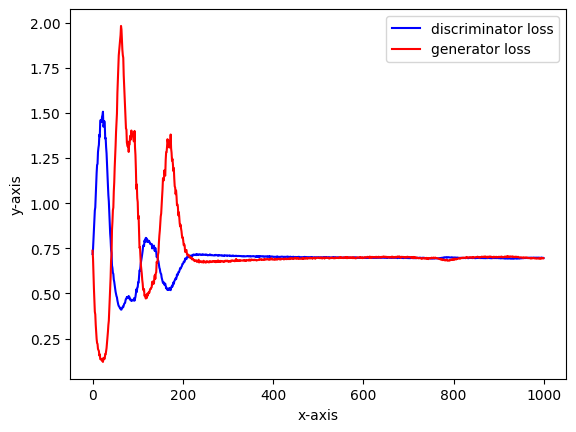

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dl, label='discriminator loss', color='blue', linestyle='-')
plt.plot(gl, label='generator loss', color='red', linestyle='-')

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

5) GENERATE DATA

In [10]:
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])

5.1) plus encode in reverse

In [11]:
# Generate 50 instances for each class
synthetic_data_class_0 = generate_data(generator, 0, 200000)
synthetic_data_class_1 = generate_data(generator, 1, 180000)
synthetic_data_class_2 = generate_data(generator, 2, 200000)
synthetic_data_class_3 = generate_data(generator, 3, 200000)
synthetic_data_class_4 = generate_data(generator, 4, 160000)
synthetic_data_class_5 = generate_data(generator, 5, 200000)

# Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
synthetic_data = pd.concat(
    [
        synthetic_data_class_0,
        synthetic_data_class_1,
        synthetic_data_class_2,
        synthetic_data_class_3,
        synthetic_data_class_4,
        synthetic_data_class_5,
    ],
    ignore_index=True,
)

COLUMNS = ["Year", "Month", "Consumption", "Consumer_number", "Installation_zone"]

generated_data_clipped = np.clip(synthetic_data, 0, 1)
synthetic_data_scaled = pd.DataFrame(
    scaler.inverse_transform(generated_data_clipped),
    columns=COLUMNS,
)
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_labels = [0] * 200000 + [1] * 180000 + [2] * 200000 + [3] * 200000 + [4] * 160000 + [5] * 200000
labels = pd.DataFrame(columns=["Consumer_type"])
labels["Consumer_type"] = synthetic_labels

synthetic_data = enc.inverse_transform(synthetic_data)
synthetic_label = enc_label.inverse_transform(labels)

6250/6250 [==============================] - 29s 5ms/step


6) UNIFY TRAIN DATASET + SYTNEHTIC DATA GENERATED AND PLOT THE NEW SITUATION

In [12]:
df = pd.DataFrame(synthetic_data, columns=COLUMNS)
df['Consumer_type'] = [item[0] for item in synthetic_label]

In [13]:
train = pd.read_csv("train_without_outliers.csv")
result = pd.concat([train, df], axis=0)
result.reset_index(inplace=True)

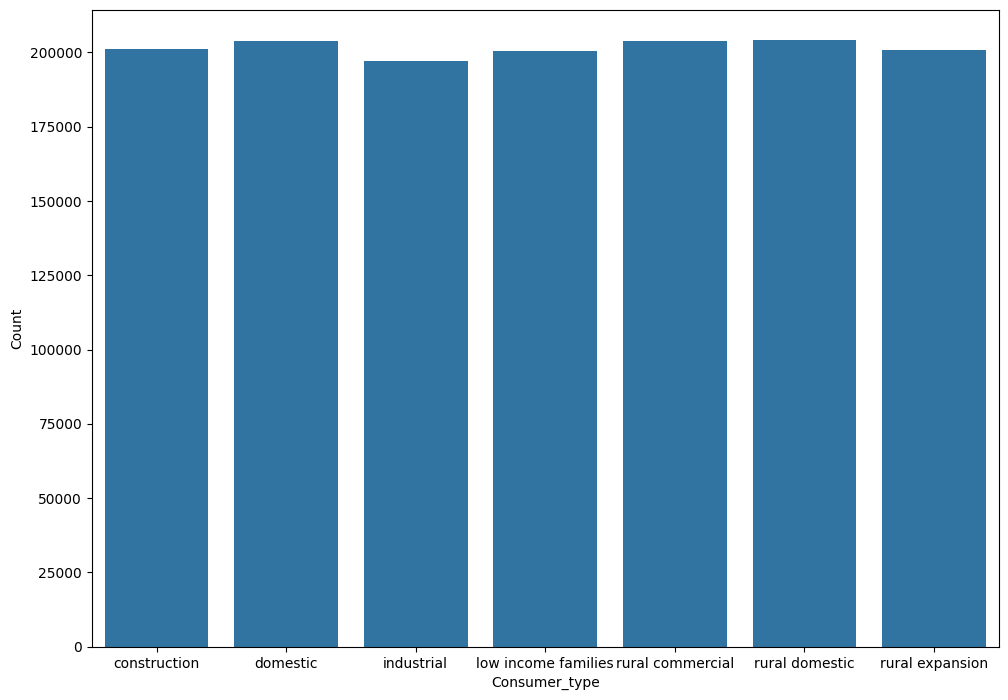

In [14]:
unb = pd.DataFrame({'Count' : result.groupby( ["Consumer_type"] ).size()}).reset_index()
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(data=unb, x=unb["Consumer_type"], y=unb["Count"])

result.to_csv('train_with_synthetic_data.csv', index=False)